In [18]:
import os
import csv
import numpy as np
from pynq import allocate
from pynq import Overlay
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

ol = Overlay('/home/xilinx/pynq/overlays/clusterOp/clusterOp.bit')

angle = np.arange(0, 360)

distance = []

with open('./data/data.csv') as lidarData:
    lidar_reader = csv.reader(lidarData)
        
    for point in lidar_reader:
        distance.append(np.uint32(point[1]))

In [19]:
#print(distance)
print(angle)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [11]:
ol.clusterOp_0.register_map

RegisterMap {
  CTRL = Register(AP_START=0, AP_DONE=0, AP_IDLE=1, AP_READY=0, RESERVED_1=0, AUTO_RESTART=0, RESERVED_2=0, INTERRUPT=0, RESERVED_3=0),
  GIER = Register(Enable=0, RESERVED=0),
  IP_IER = Register(CHAN0_INT_EN=0, CHAN1_INT_EN=0, RESERVED_0=0),
  IP_ISR = Register(CHAN0_INT_ST=0, CHAN1_INT_ST=0, RESERVED_0=0)
}

In [12]:
CONTROL_REGISTER = 0x0
ol.clusterOp_0.write(CONTROL_REGISTER, 0x81) # 0x81 will set bit 0

In [13]:
dma = ol.axi_dma
input_buffer = allocate(shape=(360,), dtype = np.uint32)
np.copyto(input_buffer, distance)
output_buffer = allocate(shape=(380,), dtype=np.uint32)
#print(input_buffer)

In [14]:
ol.clusterOp_0.write(CONTROL_REGISTER, 0x81)

In [15]:
dma.sendchannel.transfer(input_buffer)
dma.sendchannel.wait()
dma.recvchannel.transfer(output_buffer)
clusterOp_data = output_buffer

del input_buffer, output_buffer

In [16]:
cluster_n = []  # initialize empty list for first cluster
clusters = []  # initialize list to hold all clusters

for value in clusterOp_data:
    if value == 720:
        if cluster_n:  # check if cluster_n already has values
            clusters.append(cluster_n)  # if so, add it to clusters
            cluster_n = []  # reset cluster_n to empty list
    else:
        cluster_n.append(value)  # add value to current cluster

if cluster_n:  # handle the last cluster after the loop ends
    clusters.append(cluster_n)

print(clusters)  # display all clusters
    

[[0, 2, 5, 8, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 150, 151, 160, 161, 162, 175, 189, 240, 241, 275, 284, 285, 286, 287, 292, 321, 322, 323, 334, 343, 344, 357, 358], [1, 18, 29, 46, 70, 134, 164, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 288, 289, 290, 291, 338, 340, 359], [3, 4, 10, 12, 149, 163, 165, 199, 200, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 242, 276, 277, 278, 335, 339, 342, 355], [6, 7, 9, 30, 31, 77, 82, 129, 133, 156, 173, 244, 333], [11, 73, 157, 158, 159, 190, 191, 192, 193, 194, 195, 196, 197, 198, 217, 243, 279, 280, 281, 282, 283, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 341, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 356], [32, 34, 76, 79, 98, 

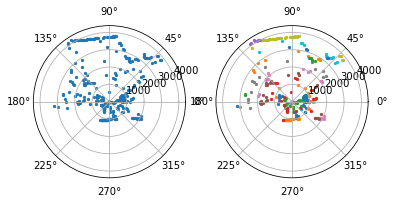

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw=dict(projection='polar'))

ax1.scatter(np.deg2rad(angle), distance, s=5)

cluster_indices = [i for i, cluster in enumerate(clusters) if len(cluster) >= 5]
for index in cluster_indices:
    group = clusters[index]
    clusterTheta = np.array(group)
    idx = np.isin(angle, clusterTheta)
    clusterDistance = np.array(distance)[np.nonzero(idx)[0]]
    ax2.scatter(np.deg2rad(clusterTheta), clusterDistance, s=5)